# Firmware System Design

## Blue Pill Specs
Technical Specifications of STM32

| Parameter           | Meaning                       |
|---------------------|-------------------------------|
| Architecture        | 32 bit ARM Cortex M3          |
| Operating Voltage    | 2.7V to 3.6V                  |
| CPU Frequency        | 72 MHz                        |
| Number of GPIO pins  | 37                            |
| Number of PWM pins   | 12                            |
| Analog Input Pins    | 10 (12 bit resolution)        |
| I2C Peripherals      | 2                             |
| SPI Peripherals      | 2                             |
| CAN 2.0 Peripheral   | 1                             |
| Timers               | 3(16-bit), 1                  |
| Flash Memory         | 64KB                          |
| RAM                  | 20kB                          |

[More information](https://stm32-base.org/boards/STM32F103C8T6-Blue-Pill.html)


# Send and Receive

## Protocols
Probably 1-wire?

## Sending a message
In this context, we assume we are trying to transmit "messages", strings of certain length.

In C, a String is stored as an array of characters (with a null byte at the end). We should keep that in mind for flash limited operations, as there will be a max size allowable that we can store.

Since the Blue Pill is very limited on flash memory (64 kB) and RAM (20 kB), it makes sense to set a 50-100 character limit (each character is one byte, so 1B).

### Encoding the messages as binary
We determined ASCII to be an appropriate encoding for the messages into binary. This is due to simplicity and familiarity with ASCII codes from the team.

> ASCII stands for American Standard Code for Information Interchange. Computers can only understand numbers, so an ASCII code is the numerical representation of a character such as 'a' or '@' or an action of some sort.

![](./asciifull.gif)

Another possible option is UTF-8, which is more commonly used today (and is better suited for multiple language support), but we decided to opt for ASCII due to its simplicity.

In [7]:
from ctypes import *
import numpy as np

The cell below showcases how a single character `"a"` can be represented by its ASCII byte equivalent. It maps to a byte that represent the decimal number 97, which can be seen above in the table

In [20]:
# Single Character
msg = "a"

# c_char_p is a ctypes string
msg_c = bytes(msg, 'ascii') 

print(msg_c)

for i in msg_c:
    print(i)

b'a'
97


In the cell below, I created a fixed length character array to mock the behavior we'd be using in C. The total number of "characters" allowed will be around 100, much like seen below.

In [24]:
NUM_CHARS = 100

# Multiple characters
msg = "hello world!"
# Create a fixed length array of characters
msg_c = (c_char*NUM_CHARS)()
msg_c.value = bytes(msg, 'ascii') 
print(msg_c.value)

for i in msg_c:
    print(i)

b'hello world!'
b'h'
b'e'
b'l'
b'l'
b'o'
b' '
b'w'
b'o'
b'r'
b'l'
b'd'
b'!'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'
b'\x00'


The actual bytes in the sequence `hello world!` is printed below.

In [26]:
for i in msg_c.value:
    print(i)

104
101
108
108
111
32
119
111
114
108
100
33


## Byte sequences to signals
Transforming byte sequences that are digital in nature into analog signals to be transmitted is what is known as modulation.

The modulation technique we're hoping to use is On-Off Keying (OOK), where an on signal *s1* represents a 1 bit and an off signal *s2* represents a 0 bit.

To take the example from above, we have the character `'a'`, which corresponds to `0110 0001` in binary.

There are several ways we can approach this:
- Sending bit by bit
  - Our signal constellation consists of two signals, one for "on" and one for "off"
- Sending by 4 bits or 1 byte
  - Instead of just transmitted 1's and 0's, we construct "signals" for a sequence of bits and bytes
  - For example, `0110` can be mapped to some signal of period T where it is on for T/2 from T/4.

In [39]:
from scipy import signal
import matplotlib.pyplot as plt

In [40]:
# # Building the amplitude modulation waveform
# f_carrier = 200e3 # 200 kHz
# f_modulated = 0.5 # 10 kHz

# Ac = 100.0 # 100 V
# Am = 1.0 # 1.0 V

# tmax = 20.0 # 20 seconds
# samples = 10000 # 10000 samples

# t = np.linspace(0, tmax, samples, endpoint=False)
# pwm = Ac/2*(signal.square(2 * np.pi*f_carrier*t, duty=0.45)+1)
# pwm_modulated = Am/2*(signal.square(2 * np.pi*f_modulated*t, duty=0.50)+1)

# # Modulate the carrier
# sig = pwm_modulated*pwm
# plt.plot(t,sig)
# plt.xlim(0,20)

In [41]:
def get_normalized_bit(value, bit_index):
    return (value >> bit_index) & 1

The code below generates a byte signal corresponding to the ASCI representation of the character being sent. In the example below, the character `a` is sent, so it should correspond to a signal that looks like `0110 0001`.

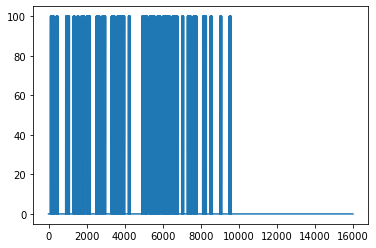

In [134]:
# AM modulation done using a character array
NUM_CHARS = 20

# Multiple characters
msg = "hello world!"
# Create a fixed length array of characters
msg_c = (c_char*NUM_CHARS)()
msg_c.value = msg.encode('ascii')

# Relate to our signal time length
Tb = 50e-6
N = 8 # 8 bits per byte
T = Tb*N # 80 us byte time

f_carrier = 200e3 # 200 kHz
f_modulated = 1/Tb # 10 kHz

Ac = 100.0 # 100 V
Am = 1.0 # 1.0 V

tmax = T # 20 seconds
samples = 100 # 10000 samples

t = np.linspace(0, tmax, samples, endpoint=False)
pwm = Ac/2*(signal.square(2 * np.pi*f_carrier*t, duty=0.45)+1)

#t = np.linspace(0, tmax, samples, endpoint=False)
t_bit = np.linspace(0, Tb, samples, endpoint=False)
pwm = Ac/2*(signal.square(2 * np.pi*f_carrier*t_bit, duty=0.45)+1)

# Get all the bits at once
sig_bits = np.unpackbits(np.frombuffer(msg_c, dtype=np.uint8))

# Create the modulated signal
mod = np.array([])

for i in range(len(sig_bits)):
    mod = np.append(mod, sig_bits[i]*pwm)

plt.plot(mod)

Assuming our channel is AWGN (should be a valid assumption at our level), we can model noise using a Gaussian distribution as shown in the cell below.

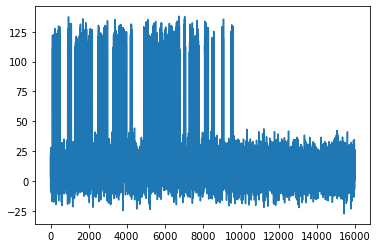

In [135]:
## Noise
# Generate noise
mu, sigma = 10, 10 # mean and standard deviation
noise = np.random.normal(mu, sigma, len(mod))

# Add noise to the signal
mod_noise = mod + noise

plt.plot(mod_noise)

I tried to get the "envelope detector" implemented in simulation below, but it ended up not modelling the actual physical one we will be using, so I abandoned it below.

In [136]:
# Envelope detection
# Get the envelope using a low pass filter
env = mod_noise

The below cells model possible scalings done on the receiver side for the signal.

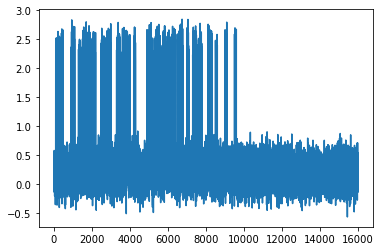

In [137]:
# Voltage divider to get it into 0-3.3 V range
# Get the envelope
v_max = 160
v_ref = 3.3

scaled = env/v_max*v_ref
plt.plot(scaled)

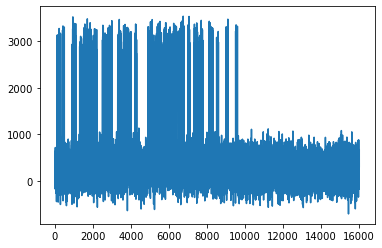

In [138]:
# ADC conversion
## Based on this tutorial: https://learn.adafruit.com/circuitpython-basics-analog-inputs-and-outputs/analog-to-digital-converter-inputs

bit_resolution = 12 # 12 bits
v_ref = 3.3 # 3.3 V

adcout = (scaled/v_ref*2**bit_resolution).astype(int)

plt.plot(adcout)

In [139]:
import cmsisdsp as dsp

In [140]:
# Separate into bit windows
# Get the bit windows
window_size = len(adcout)/8

For "demodulation", I separated each bit into its corresponding window size and then looked at it bit-by-bit. We can also consider doing this for a longer sequence of bits and then using correlation to figure out the bytes.

The cell below shows "demodulation" by just taking the average of the received signal.

In [141]:
from ipywidgets import interact, widgets

# Define a function to plot the i-th index of y
def plot_i(i):
    sig = adcout[i*100:(i+1)*100]
    plt.plot(sig)
    # Get the mean
    mea = dsp.arm_mean_q15(sig)

    decision_thres = 500

    if mea > decision_thres:
        decision = 1
    else:
        decision = 0

    plt.title(f"Index {i} with mean {mea} and bit {decision}")
    plt.xlim(0,100)
    plt.ylim(0,2**bit_resolution)
    plt.show()

# Create a slider widget for integer i
slider_i = widgets.IntSlider(value=0, min=0, max=7, step=1, description='Index i:')

# Use the interact function to link the slider with the plot function
interact(plot_i, i=slider_i)


interactive(children=(IntSlider(value=0, description='Index i:', max=7), Output()), _dom_classes=('widget-inte…

<function __main__.plot_i(i)>

The cell below tries a similar approach, but correlates the signal to a square wave first.

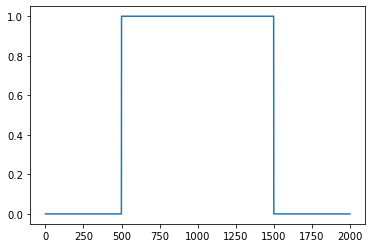

In [142]:
# Generating fake "square" pulses for correlation

num_fft_bins = int(window_size // 2 + 1)

window_size = int(window_size)
square = np.zeros(window_size)

for i in range(int(window_size/4), int(window_size*3/4)):
    square[i] = 1

plt.plot(square)

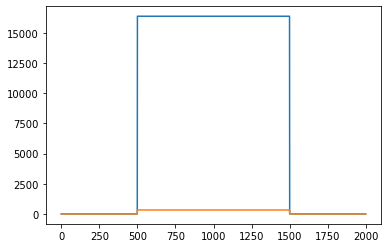

In [143]:
s1 = dsp.arm_float_to_q15(0.5*square)
s2 = dsp.arm_float_to_q15(0.01*square)

plt.plot(s1)
plt.plot(s2)

In [144]:
from ipywidgets import interact, widgets

# Define a function to plot the i-th index of y
def plot_conv(i):
    sig = adcout[i*100:(i+1)*100]
    r1 = dsp.arm_correlate_q15(sig, len(sig),s1, len(s1))

    if dsp.arm_mean_q15(r1) > 5000:
        decision = 1
    else:
        decision = 0  
    print(decision)
    plt.plot(r1)
    plt.plot(adcout[i*100:(i+1)*100])
    plt.title(f"Index {i}")
    plt.show()

# Create a slider widget for integer i
slider_i = widgets.IntSlider(value=0, min=0, max=7, step=1, description='Index i:')

# Use the interact function to link the slider with the plot function
interact(plot_conv, i=slider_i)

interactive(children=(IntSlider(value=0, description='Index i:', max=7), Output()), _dom_classes=('widget-inte…

<function __main__.plot_conv(i)>

Decoding it below:

In [149]:
threshold = 7000 # play around with this value for better decoding

results_lst = []
char_lst = []
for i in range(len(adcout)//100):
    sig = adcout[i*100:(i+1)*100]
    r1 = dsp.arm_correlate_q15(sig, len(sig), s1, len(s1))

    if dsp.arm_mean_q15(r1) > threshold:
        char_lst.append('1')
    else:
        char_lst.append('0')

    # If we have 8 bits (i.e., one ASCII character) in char_lst, convert it to a string
    if len(char_lst) == 8:
        char_str = ''.join(char_lst)
        results_lst.append(chr(int(char_str, 2)))
        char_lst = []

# If there are remaining bits in the last chunk, pad with zeros and convert to a string
if len(char_lst) > 0:
    while len(char_lst) < 8:
        char_lst.append('0')
    char_str = ''.join(char_lst)
    results_lst.append(chr(int(char_str, 2)))

results = np.array(results_lst, dtype='str')
print(results)

['h' 'e' 'l' 'l' 'o' ' ' 'w' 'o' 'r' 'l' 'd' '!' '' '' '' '' '' '' '' '']


GOOD RESOURCES TO READ:
- https://pysdr.org/content/digital_modulation.html
- https://pysdr.org/content/filters.html
- https://pysdr.org/content/pulse_shaping.html

TODO/QUESTIONS I HAVE:
- Matched filters
  - We might want to actually think about Pulse-Shaping strategies. They mitigate symbol interference (which can easily occur due to multi-path propagation).
  - Matched filter design? I don't quite actually utilize it to decode the message
- What other "processes" are needed on the receiver side?